## 数据清洗

In [1]:
from pyspark import  SparkContext
from pyspark.sql import  SparkSession
from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

In [2]:
#get data
logfile='hdfs://node1:8020//test//PM25city.csv'
# data = SparkContext("local", "first app").textFile(logfile)
# print(data.count())

spark=SparkSession.builder.appName("PM25city").master("local").getOrCreate()
df=spark.read.csv(logfile, header=True)

print(df.count())
df.printSchema()

398355
root
 |-- 站号: string (nullable = true)
 |-- 经度: string (nullable = true)
 |-- 纬度: string (nullable = true)
 |-- PM25: string (nullable = true)
 |-- PM10: string (nullable = true)
 |-- NO2: string (nullable = true)
 |-- SO2: string (nullable = true)
 |-- O3-1: string (nullable = true)
 |-- O3-8h: string (nullable = true)
 |-- CO: string (nullable = true)
 |-- AQI: string (nullable = true)
 |-- 等级: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- city: string (nullable = true)



In [4]:
#检查重复行
df.distinct().count()

398355

In [5]:
#去除null和NaN
df.na.drop().show(5)
print(df.count())

+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
| 站号|  经度| 纬度|PM25|PM10|NO2|SO2|O3-1|O3-8h| CO|AQI|等级|year|month|day|hour|city|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
|99000|115.49|38.88|  43|  68| 21| 20| 104|  104|0.6| 60|   2|2018|    8|  1|   0|北京|
|99001|115.51|38.88|  38|  58| 26| 20| 120|  120|0.6| 54|   2|2018|    8|  1|   0|北京|
|99002|115.47|38.91|  50|  72| 22| 17| 113|  113|0.7| 69|   2|2018|    8|  1|   0|北京|
|99004|115.45|38.88|  52| 108| 46| 21|  66|   66|0.7| 79|   2|2018|    8|  1|   0|北京|
|99006|116.36|39.87|  55|  80| 27|  2|  60|   60|1.3| 75|   2|2018|    8|  1|   0|北京|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
only showing top 5 rows

398355


In [6]:
df.where(df['AQI'].isNull()).count()

0

In [7]:
#将数值字段类型转换成Int

data_df = df.withColumn("PM25", df.PM25.cast(FloatType()))
data_df = data_df.withColumn("PM10", df.PM10.cast(FloatType()))
data_df = data_df.withColumn("NO2", df.NO2.cast(FloatType()))
data_df = data_df.withColumn("SO2", df.SO2.cast(FloatType()))
data_df = data_df.withColumn("O3-1", df['O3-1'].cast(FloatType()))
data_df = data_df.withColumn("O3-8h", df['O3-8h'].cast(FloatType()))
data_df = data_df.withColumn("CO", df.CO.cast(FloatType()))
data_df = data_df.withColumn("AQI", df.AQI.cast(FloatType()))
data_df = data_df.withColumn("等级", df['等级'].cast(FloatType()))
data_df.printSchema()

root
 |-- 站号: string (nullable = true)
 |-- 经度: string (nullable = true)
 |-- 纬度: string (nullable = true)
 |-- PM25: float (nullable = true)
 |-- PM10: float (nullable = true)
 |-- NO2: float (nullable = true)
 |-- SO2: float (nullable = true)
 |-- O3-1: float (nullable = true)
 |-- O3-8h: float (nullable = true)
 |-- CO: float (nullable = true)
 |-- AQI: float (nullable = true)
 |-- 等级: float (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- city: string (nullable = true)



In [8]:
#统计数据

summary=data_df.summary()

summary.select(summary["summary"],bround("PM25", scale=1).alias("PM25"),
                bround("PM10", scale=1).alias("PM10"),
                bround("NO2", scale=1).alias("NO2"),
                bround("SO2", scale=1).alias("SO2"),
                bround("O3-1", scale=1).alias("O3-1"),
                bround("O3-8h", scale=1).alias("O3-8h"),
                bround("CO", scale=1).alias("CO"),
               ).show()

+-------+--------+--------+--------+--------+--------+--------+--------+
|summary|    PM25|    PM10|     NO2|     SO2|    O3-1|   O3-8h|      CO|
+-------+--------+--------+--------+--------+--------+--------+--------+
|  count|398355.0|398355.0|398355.0|398355.0|398355.0|398355.0|398355.0|
|   mean|    58.7|    93.7|    38.1|    13.3|    54.6|    52.6|     1.1|
| stddev|    57.2|    76.7|    27.3|    13.7|    44.9|    40.5|     0.7|
|    min|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|     0.0|
|    25%|    20.0|    40.0|    16.0|     5.0|    20.0|    22.0|     0.6|
|    50%|    39.0|    71.0|    31.0|     9.0|    48.0|    46.0|     0.9|
|    75%|    78.0|   122.0|    55.0|    16.0|    74.0|    70.0|     1.3|
|    max|   589.0|  1384.0|   339.0|   489.0|   642.0|   300.0|    14.3|
+-------+--------+--------+--------+--------+--------+--------+--------+



In [9]:
#统计每个城市的样本数据数量
df_city = data_df.groupBy('city').count()
df_city.show()

+--------+-----+
|    city|count|
+--------+-----+
|    昆明|17223|
|    天津|55384|
|    成都|41165|
|    郑州|54302|
|    厦门|22304|
|    青岛|39335|
|    济南|37609|
|呼和浩特|13728|
|    上海|55441|
|    海口| 9398|
|乌鲁木齐|14838|
|    北京|37628|
+--------+-----+



In [10]:
#按天统计数据
data_df.groupby("year","month","day","city").count().show()


+----+-----+---+--------+-----+
|year|month|day|    city|count|
+----+-----+---+--------+-----+
|2019|    2| 13|    昆明|  181|
|2019|    1|  1|    北京|  370|
|2019|    1|  8|    青岛|  483|
|2019|    1| 18|    济南|  504|
|2019|    1| 13|    郑州|  690|
|2019|    1| 11|乌鲁木齐|  213|
|2019|    1| 30|    昆明|  218|
|2018|    8| 19|    北京|  388|
|2018|    8| 24|    北京|  215|
|2019|    2| 16|    北京|  519|
|2019|    2| 19|    北京|  241|
|2018|    8|  6|    上海|  596|
|2018|    8| 18|    济南|  327|
|2019|    2| 11|    济南|  473|
|2019|    2| 10|    厦门|  257|
|2018|    8|  8|乌鲁木齐|  153|
|2019|    2| 22|乌鲁木齐|  129|
|2018|    8|  8|呼和浩特|   75|
|2019|    1|  1|呼和浩特|  158|
|2019|    6| 10|呼和浩特|  178|
+----+-----+---+--------+-----+
only showing top 20 rows



In [20]:
data_df.groupby("year","month").count().show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2018|    8|100045|
|2019|    6| 13909|
|2019|    2|129797|
|2019|    1|154604|
+----+-----+------+



In [14]:
#按工作站和天统计数据
df_place=data_df.groupby("站号","year","month","day","city").count()
df_place.show()
df_place.count()

+-----+----+-----+---+----+-----+
| 站号|year|month|day|city|count|
+-----+----+-----+---+----+-----+
|99006|2018|    8|  4|北京|   20|
|99011|2018|    8|  5|北京|   19|
|99009|2018|    8|  6|北京|   17|
|99014|2018|    8| 23|北京|   18|
|95107|2018|    8| 26|北京|    3|
|95117|2019|    1|  2|北京|   12|
|98090|2019|    1|  6|北京|   24|
|99012|2019|    1| 15|北京|   22|
|99012|2019|    1| 29|北京|   24|
|95102|2019|    2|  1|北京|   18|
|99013|2019|    2|  6|北京|   24|
|99721|2018|    8| 18|上海|   18|
|99300|2018|    8| 22|上海|   19|
|99866|2018|    8| 23|上海|   17|
|99722|2018|    8| 27|上海|   17|
|99301|2019|    1|  3|上海|   22|
|99270|2019|    1| 11|上海|   13|
|99352|2019|    1| 19|上海|   16|
|99697|2019|    1| 22|上海|   17|
|99300|2019|    1| 30|上海|   24|
+-----+----+-----+---+----+-----+
only showing top 20 rows



21842

In [15]:
# 查看PM25或者PM10为0的行
data_0 = data_df.filter(( data_df['PM25']==0) | (data_df['PM10']==0))
data_0.show()
data_0.count()

+-----+------+-----+----+----+----+---+-----+-----+---+----+----+----+-----+---+----+----+
| 站号|  经度| 纬度|PM25|PM10| NO2|SO2| O3-1|O3-8h| CO| AQI|等级|year|month|day|hour|city|
+-----+------+-----+----+----+----+---+-----+-----+---+----+----+----+-----+---+----+----+
|95105|117.15|38.91|35.0| 0.0|21.0|5.0| 86.0| 51.0|1.0|50.0| 1.0|2018|    8| 30|  16|北京|
|95107|117.14|39.16|11.0| 0.0|32.0|4.0| 76.0| 56.0|0.6|24.0| 1.0|2018|    8| 30|  16|北京|
|95116|117.15|39.08|21.0| 0.0|21.0|4.0| 96.0| 65.0|0.7|30.0| 1.0|2018|    8| 30|  16|北京|
|95117|117.19| 39.1| 8.0| 0.0|22.0|2.0| 85.0| 59.0|0.6|27.0| 1.0|2018|    8| 30|  16|北京|
|99006|116.36|39.86| 5.0| 0.0| 9.0|3.0| 82.0| 56.0|0.5|26.0| 1.0|2018|    8| 30|  16|北京|
|99007|116.16|40.28| 9.0| 0.0| 9.0|3.0| 98.0| 67.0|0.4|31.0| 1.0|2018|    8| 30|  16|北京|
|99008|116.43|39.95| 8.0| 0.0|13.0|1.0|102.0| 67.0|0.4|32.0| 1.0|2018|    8| 30|  16|北京|
|99009|116.43|39.87| 8.0| 0.0| 8.0|3.0| 99.0| 68.0|0.7|31.0| 1.0|2018|    8| 30|  16|北京|
|99010|116.47|39.97| 3.

864

In [24]:
# 查看PM25值大于PM10为0的行
data_df.filter( data_df['PM25']>data_df['PM10'] ).count()

521

In [17]:
data_df.filter(( data_df['PM25']!=0) & (data_df['PM10']==0)).count()

454

In [95]:
#对值为0的数据按照城市汇总
data_0.groupby("city").count().show()  

+--------+-----+
|    city|count|
+--------+-----+
|    昆明|  109|
|    天津|  181|
|    成都|   32|
|    郑州|   64|
|    厦门|   38|
|    青岛|   77|
|    济南|   51|
|呼和浩特|   13|
|    上海|  131|
|    海口|    5|
|乌鲁木齐|   66|
|    北京|   97|
+--------+-----+



In [23]:
# 去除PM25或者PM10为0的行
data = data_df.filter(( data_df['PM25']!=0) & (data_df['PM10']!=0)))
data.show(5)
data.count()

+-----+------+-----+----+-----+----+----+-----+-----+---+----+----+----+-----+---+----+----+
| 站号|  经度| 纬度|PM25| PM10| NO2| SO2| O3-1|O3-8h| CO| AQI|等级|year|month|day|hour|city|
+-----+------+-----+----+-----+----+----+-----+-----+---+----+----+----+-----+---+----+----+
|99000|115.49|38.88|43.0| 68.0|21.0|20.0|104.0|104.0|0.6|60.0| 2.0|2018|    8|  1|   0|北京|
|99001|115.51|38.88|38.0| 58.0|26.0|20.0|120.0|120.0|0.6|54.0| 2.0|2018|    8|  1|   0|北京|
|99002|115.47|38.91|50.0| 72.0|22.0|17.0|113.0|113.0|0.7|69.0| 2.0|2018|    8|  1|   0|北京|
|99004|115.45|38.88|52.0|108.0|46.0|21.0| 66.0| 66.0|0.7|79.0| 2.0|2018|    8|  1|   0|北京|
|99006|116.36|39.87|55.0| 80.0|27.0| 2.0| 60.0| 60.0|1.3|75.0| 2.0|2018|    8|  1|   0|北京|
+-----+------+-----+----+-----+----+----+-----+-----+---+----+----+----+-----+---+----+----+
only showing top 5 rows



393187

In [28]:
#统计噪声处理后的样本数据
new_df_city = data.groupBy('city').count()
new_df_city.show()

+--------+-----+
|    city|count|
+--------+-----+
|    昆明|16724|
|    天津|54657|
|    成都|40965|
|    郑州|53960|
|    厦门|21713|
|    青岛|39101|
|    济南|37464|
|呼和浩特|13629|
|    上海|54009|
|    海口| 9274|
|乌鲁木齐|14543|
|    北京|37148|
+--------+-----+



In [31]:
day_avg=data.groupby("year","month","day","city").avg("PM25")
day_avg.groupby("city").count().show()

+--------+-----+
|    city|count|
+--------+-----+
|    昆明|   92|
|    天津|   92|
|    成都|   92|
|    郑州|   92|
|    厦门|   92|
|    青岛|   92|
|    济南|   92|
|呼和浩特|   92|
|    上海|   92|
|    海口|   92|
|乌鲁木齐|   92|
|    北京|   92|
+--------+-----+



## 1. Which city has the highest PM25 index, and which city has the lowest PM25 index? 

In [98]:
#计算PM25空气质量分指数:24小时平均 --》IAQI  
#24小时平均值统计
data_24h = data.groupby("year","month","day","city").avg("PM25")
data_24h.show(20)
data_24h.count()

+----+-----+---+--------+------------------+
|year|month|day|    city|         avg(PM25)|
+----+-----+---+--------+------------------+
|2019|    2| 13|    昆明| 58.41988950276243|
|2019|    1|  1|    北京| 53.81891891891892|
|2019|    1|  8|    青岛| 61.97929606625259|
|2019|    1| 18|    济南|  97.8234126984127|
|2019|    1| 13|    郑州|159.02898550724638|
|2019|    1| 11|乌鲁木齐|171.98591549295776|
|2019|    1| 30|    昆明|21.798165137614678|
|2018|    8| 19|    北京|  23.7680412371134|
|2018|    8| 24|    北京| 19.11627906976744|
|2019|    2| 16|    北京|12.017341040462428|
|2019|    2| 19|    北京|120.46058091286307|
|2018|    8|  6|    上海| 26.17953020134228|
|2018|    8| 18|    济南| 28.61467889908257|
|2019|    2| 11|    济南|  87.5031712473573|
|2019|    2| 10|    厦门|10.797665369649806|
|2018|    8|  8|乌鲁木齐| 26.11111111111111|
|2019|    2| 22|乌鲁木齐| 61.83720930232558|
|2018|    8|  8|呼和浩特| 9.866666666666667|
|2019|    1|  1|呼和浩特| 41.75949367088607|
|2019|    6| 10|呼和浩特| 9.297752808988765|
+----+-----+---+-

1104

In [99]:
#统计数据
summary_24h=data_24h.summary()
summary_24h.select(summary_24h["summary"],bround("avg(PM25)", scale=2).alias("PM25")).show()

+-------+------+
|summary|  PM25|
+-------+------+
|  count|1104.0|
|   mean| 50.65|
| stddev| 44.14|
|    min|  5.76|
|    25%| 20.06|
|    50%| 34.34|
|    75%| 64.21|
|    max| 249.7|
+-------+------+



In [100]:
#按天计算PM25的IAQI值
def IAQI(num,array_num,array_IAQI):
    length=len(array_num)
    for i in range(length-1):
        if array_num[i]<= num <array_num[i+1]:
            sum=(array_IAQI[i+1]-array_IAQI[i])/(array_num[i+1]-array_num[i])*(num-array_num[i])+array_IAQI[i]
            return  sum

array_IAQI=[0,50,100,150,200,300,400,500]
array_num=[0,35,75,115,150,250,350,500]
cal_PM25=udf(lambda x:IAQI(x,array_num,array_IAQI),FloatType())

data_PM25=data_24h.select("year","month","day","city","avg(PM25)",cal_PM25("avg(PM25)").alias("IAQI_PM25"))
data_PM25.show()

+----+-----+---+--------+------------------+---------+
|year|month|day|    city|         avg(PM25)|IAQI_PM25|
+----+-----+---+--------+------------------+---------+
|2019|    2| 13|    昆明| 58.41988950276243|79.274864|
|2019|    1|  1|    北京| 53.81891891891892| 73.52365|
|2019|    1|  8|    青岛| 61.97929606625259| 83.72412|
|2019|    1| 18|    济南|  97.8234126984127|128.52927|
|2019|    1| 13|    郑州|159.02898550724638|209.02899|
|2019|    1| 11|乌鲁木齐|171.98591549295776|221.98592|
|2019|    1| 30|    昆明|21.798165137614678|31.140236|
|2018|    8| 19|    北京|  23.7680412371134|33.954346|
|2018|    8| 24|    北京| 19.11627906976744| 27.30897|
|2019|    2| 16|    北京|12.017341040462428| 17.16763|
|2019|    2| 19|    北京|120.46058091286307|157.80083|
|2018|    8|  6|    上海| 26.17953020134228| 37.39933|
|2018|    8| 18|    济南| 28.61467889908257|40.878113|
|2019|    2| 11|    济南|  87.5031712473573|115.62897|
|2019|    2| 10|    厦门|10.797665369649806|15.425237|
|2018|    8|  8|乌鲁木齐| 26.11111111111111|37

In [189]:
#按城市平均24小时制IAQI 
PM25mean=data_PM25.groupBy("city").mean("avg(PM25)","IAQI_PM25")
PM25mean.sort("avg(IAQI_PM25)",ascending=False).show()

+--------+------------------+------------------+
|    city|    avg(avg(PM25))|    avg(IAQI_PM25)|
+--------+------------------+------------------+
|    郑州| 89.02165668978283| 117.3464706669683|
|乌鲁木齐|  76.2208478565875|101.15932715457419|
|    济南| 75.27799497185896| 99.87255767117377|
|    天津| 57.26429681929151| 76.81578493118286|
|    青岛| 56.64780075601097| 75.74151861149332|
|    北京|55.803787747316846|  75.2026127214017|
|    成都| 51.03605982541247| 69.47023186476335|
|    上海| 40.53451128169592|  55.5008091200953|
|呼和浩特| 39.08317152889515|53.518282154332034|
|    厦门| 26.82438842255263| 37.80141546415246|
|    昆明|24.186494910050758|34.375241922295615|
|    海口|15.885108029339362|22.664399095203567|
+--------+------------------+------------------+



In [162]:
#计算PM25 等级
def level(num,array_num,array_AQI):
    length=len(array_num)
    if num==0:
        return array_num[0]
    for i in range(length-1):
        if array_AQI[i]< num <= array_AQI[i+1]:
            return  array_num[i]
    return array_num[5]

PM_IAQI=[0,50,100,150,200,300]
num=[1,2,3,4,5,6]

cal_PM25_level=udf(lambda x:level(x,num,PM_IAQI),IntegerType())
       
data_PM25_level=data_PM25.select("year","month","day","city","IAQI_PM25",cal_PM25_level("IAQI_PM25").alias("PM25_等级"))

data_PM25_level.show()

data_PM25_level.count()

+----+-----+---+--------+---------+---------+
|year|month|day|    city|IAQI_PM25|PM25_等级|
+----+-----+---+--------+---------+---------+
|2019|    2| 13|    昆明|79.274864|        2|
|2019|    1|  1|    北京| 73.52365|        2|
|2019|    1|  8|    青岛| 83.72412|        2|
|2019|    1| 18|    济南|128.52927|        3|
|2019|    1| 13|    郑州|209.02899|        5|
|2019|    1| 11|乌鲁木齐|221.98592|        5|
|2019|    1| 30|    昆明|31.140236|        1|
|2018|    8| 19|    北京|33.954346|        1|
|2018|    8| 24|    北京| 27.30897|        1|
|2019|    2| 16|    北京| 17.16763|        1|
|2019|    2| 19|    北京|157.80083|        4|
|2018|    8|  6|    上海| 37.39933|        1|
|2018|    8| 18|    济南|40.878113|        1|
|2019|    2| 11|    济南|115.62897|        3|
|2019|    2| 10|    厦门|15.425237|        1|
|2018|    8|  8|乌鲁木齐|37.301586|        1|
|2019|    2| 22|乌鲁木齐| 83.54651|        2|
|2018|    8|  8|呼和浩特|14.095238|        1|
|2019|    1|  1|呼和浩特|58.449368|        2|
|2019|    6| 10|呼和浩特|13.282504|       

1104

In [103]:
data_PM25_level.groupby("city").count().show()

+--------+-----+
|    city|count|
+--------+-----+
|    昆明|   92|
|    天津|   92|
|    成都|   92|
|    郑州|   92|
|    厦门|   92|
|    青岛|   92|
|    济南|   92|
|呼和浩特|   92|
|    上海|   92|
|    海口|   92|
|乌鲁木齐|   92|
|    北京|   92|
+--------+-----+



In [190]:
#优良城市天数汇总并排名
data_PM25_level.filter(data_PM25_level["PM25_等级"]<3).groupby("city").count().sort("count",ascending=True).show()

+--------+-----+
|    city|count|
+--------+-----+
|    郑州|   49|
|乌鲁木齐|   54|
|    济南|   55|
|    青岛|   64|
|    北京|   73|
|    天津|   74|
|    成都|   75|
|    上海|   77|
|呼和浩特|   80|
|    厦门|   91|
|    昆明|   92|
|    海口|   92|
+--------+-----+



## 2. Please report the air quality distribution of 北京, 上海 and 成都 throughout February in the year of 2019.

### 2.1 北京

In [106]:
#按照 city=北京 筛选 year=2019, month=2的数据
df_bj = data.filter((data_df.city == '北京') & (data_df.year == '2019') &(data_df.month == '2') )
print(df_bj.count())
df_bj.show(5)

11820
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
| 站号|  经度| 纬度|PM25|PM10|NO2|SO2|O3-1|O3-8h| CO|AQI|等级|year|month|day|hour|city|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
|92030| 116.7|39.54|  41|  92| 29| 18|  33|   41|  0| 71|   2|2019|    2|  1|   0|北京|
|95102|117.18|39.21|  43| 103| 26| 16|  40|   43|  0| 77|   2|2019|    2|  1|   0|北京|
|95105|117.15|38.91|  48|  84| 35| 16|  32|   51|  0| 67|   2|2019|    2|  1|   0|北京|
|95107|117.14|39.16|  47| 109| 24| 20|  37|   40|  0| 80|   2|2019|    2|  1|   0|北京|
|95116|117.15|39.08|  44|  73| 38| 17|  26|   36|  0| 62|   2|2019|    2|  1|   0|北京|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
only showing top 5 rows



In [107]:
#df_bj 按24h汇总
bj_24h_1 = df_bj.groupby("year","month","day","city").avg("PM25",'PM10','NO2','SO2','CO')
bj_24h_2 = df_bj.groupby("year","month","day","city").max('O3-1','O3-8h')
bj_24=bj_24h_1.join(bj_24h_2,["year","month","day","city"],"inner")
bj_24.show(5)
bj_24.count()

+----+-----+---+----+------------------+------------------+------------------+------------------+--------------------+---------+----------+
|year|month|day|city|         avg(PM25)|         avg(PM10)|          avg(NO2)|          avg(SO2)|             avg(CO)|max(O3-1)|max(O3-8h)|
+----+-----+---+----+------------------+------------------+------------------+------------------+--------------------+---------+----------+
|2019|    2| 16|北京|12.017341040462428|24.990366088631983|16.764932562620423| 4.911368015414258|0.036608863198458574|       96|        93|
|2019|    2| 19|北京|120.46058091286307|144.08713692946057| 36.46058091286307| 7.614107883817427|  0.7800829875518672|      100|        94|
|2019|    2| 20|北京| 97.65074626865672|121.17611940298508|38.191044776119405| 6.119402985074627|  0.5432835820895522|      123|       104|
|2019|    2|  2|北京|108.58691206543968|144.23108384458078|44.717791411042946| 9.642126789366053|  1.0838445807770962|       63|        65|
|2019|    2|  9|北京|16.110878

28

In [108]:
#计算'PM10','NO2','SO2','O3-1','O3-8h','CO'的IAQI 
#计算'PM10'IAQI公式

array_IAQI_PM10=[0,50,150,250,350,420,500,600]
cal_PM10=udf(lambda x:IAQI(x,array_IAQI_PM10,array_IAQI),FloatType())

array_IAQI_SO2=[0,50,150,475,800,1600,2100,2620]
cal_SO2=udf(lambda x:IAQI(x,array_IAQI_SO2,array_IAQI),FloatType())

array_IAQI_NO2=[0,40,80,180,280,565,750,940]
cal_NO2=udf(lambda x:IAQI(x,array_IAQI_NO2,array_IAQI),FloatType())

array_IAQI_CO=[0,2,4,14,24,36,48,60]
cal_CO=udf(lambda x:IAQI(x,array_IAQI_CO,array_IAQI),FloatType())

array_IAQI_O31h=[0,160,200,300,400,800,1000,1200]
cal_O31h=udf(lambda x:IAQI(x,array_IAQI_O31h,array_IAQI),FloatType())

array_IAQI_O38h=[0,100,160,215,265,800,800,800]
cal_O38h=udf(lambda x:IAQI(x,array_IAQI_O38h,array_IAQI),FloatType())

#按日计算7项IAQI  
bj_24_IAQI=bj_24.select("year","month","day","city",cal_PM25("avg(PM25)").alias("PM25"),
                      cal_PM10('avg(PM10)').alias("PM10"),cal_NO2('avg(NO2)').alias("NO2"),
                      cal_SO2('avg(SO2)').alias("SO2"),cal_CO('avg(CO)').alias("CO"),
                      cal_O31h('max(O3-1)').alias("O3-1"),cal_O38h('max(O3-8h)').alias("O3-8h"))
bj_24_IAQI.show(28)
bj_24_IAQI.printSchema()

+----+-----+---+----+---------+----------+---------+----------+----------+-------+---------+
|year|month|day|city|     PM25|      PM10|      NO2|       SO2|        CO|   O3-1|    O3-8h|
+----+-----+---+----+---------+----------+---------+----------+----------+-------+---------+
|2019|    2| 16|北京| 17.16763| 24.990366|20.956165|  4.911368| 0.9152216|   30.0|     46.5|
|2019|    2| 19|北京|157.80083|  97.04357|45.575726|  7.614108| 19.502075|  31.25|     47.0|
|2019|    2| 20|北京|128.31343|  85.58806|47.738808|  6.119403| 13.582089|38.4375|53.333332|
|2019|    2|  2|北京|141.98364|  97.11554| 55.89724|  9.642127| 27.096115|19.6875|     32.5|
|2019|    2|  9|北京|23.015541| 29.209206| 17.24634|  5.740586|0.83682007| 25.625|     41.0|
|2019|    2|  4|北京| 82.06731|  91.34249|31.423992| 10.331502| 13.186813|   35.0|     44.5|
|2019|    2| 25|北京| 72.01691|  64.40096| 66.08092| 17.391304| 19.142511|33.4375|     41.5|
|2019|    2| 11|北京|81.069336|  65.06055|41.516113|11.7421875|15.0390625|27.1875|    

In [109]:
def cal(a,b,c,d,e,f,g):
    #最大值函数
    num=0
    for i in (a,b,c,d,e,f,g):
        if i>num:
            num=i
    return  num

cal_AQI=udf(cal,FloatType())
bj_AQI=bj_24_IAQI.select("year","month","day","city",cal_AQI("PM25",'PM10','NO2','SO2','O3-1','O3-8h','CO').alias("AQI_day"))
bj_AQI.show()

+----+-----+---+----+----------+
|year|month|day|city|   AQI_day|
+----+-----+---+----+----------+
|2019|    2| 16|北京|      46.5|
|2019|    2| 19|北京| 157.80083|
|2019|    2| 20|北京| 128.31343|
|2019|    2|  2|北京| 141.98364|
|2019|    2|  9|北京|      41.0|
|2019|    2|  4|北京|  91.34249|
|2019|    2| 25|北京|  72.01691|
|2019|    2| 11|北京| 81.069336|
|2019|    2|  7|北京|      45.5|
|2019|    2| 27|北京| 100.39375|
|2019|    2| 22|北京|  220.0795|
|2019|    2| 26|北京|  73.72385|
|2019|    2|  5|北京|  153.0444|
|2019|    2|  3|北京|106.475044|
|2019|    2|  1|北京|   79.1186|
|2019|    2| 24|北京| 163.55922|
|2019|    2|  8|北京| 49.162426|
|2019|    2| 28|北京| 138.99336|
|2019|    2| 17|北京|      43.0|
|2019|    2| 15|北京|      43.0|
+----+-----+---+----+----------+
only showing top 20 rows



In [163]:
#计算等级

array_AQI=[0,50,100,150,200,300]
array_num=[1,2,3,4,5,6]

cal_level=udf(lambda x:level(x,array_num,array_AQI),IntegerType())
       
bj_level=bj_AQI.select("year","month","day","city","AQI_day",cal_level("AQI_day").alias("等级_day"))
bj_level.show()

+----+-----+---+----+----------+--------+
|year|month|day|city|   AQI_day|等级_day|
+----+-----+---+----+----------+--------+
|2019|    2| 16|北京|      46.5|       1|
|2019|    2| 19|北京| 157.80083|       4|
|2019|    2| 20|北京| 128.31343|       3|
|2019|    2|  2|北京| 141.98364|       3|
|2019|    2|  9|北京|      41.0|       1|
|2019|    2|  4|北京|  91.34249|       2|
|2019|    2| 25|北京|  72.01691|       2|
|2019|    2| 11|北京| 81.069336|       2|
|2019|    2|  7|北京|      45.5|       1|
|2019|    2| 27|北京| 100.39375|       3|
|2019|    2| 22|北京|  220.0795|       5|
|2019|    2| 26|北京|  73.72385|       2|
|2019|    2|  5|北京|  153.0444|       4|
|2019|    2|  3|北京|106.475044|       3|
|2019|    2|  1|北京|   79.1186|       2|
|2019|    2| 24|北京| 163.55922|       4|
|2019|    2|  8|北京| 49.162426|       1|
|2019|    2| 28|北京| 138.99336|       3|
|2019|    2| 17|北京|      43.0|       1|
|2019|    2| 15|北京|      43.0|       1|
+----+-----+---+----+----------+--------+
only showing top 20 rows



In [192]:
bj_level.groupby("等级_day").count().show()

+--------+-----+
|等级_day|count|
+--------+-----+
|       1|    7|
|       3|    5|
|       5|    2|
|       4|    4|
|       2|   10|
+--------+-----+



### 2.2 成都

In [111]:
df_cd = data.filter((data_df.city == '成都') & (data_df.year == '2019') &(data_df.month == '2') )
print(df_cd.count())
df_cd.show(5)

15280
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
| 站号|  经度| 纬度|PM25|PM10|NO2|SO2|O3-1|O3-8h| CO|AQI|等级|year|month|day|hour|city|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
|92017|104.02|30.65|  65|  91| 54|  4|  17|   36|  0| 88|   2|2019|    2|  1|   0|成都|
|92089|104.27|30.55|  83| 101| 36|  6|  13|   23|  0|110|   3|2019|    2|  1|   0|成都|
|92090|103.85|30.07|  74|  86| 38|  6|  14|   19|  1| 99|   2|2019|    2|  1|   0|成都|
|92096|103.82|30.05|  54|  73| 38|  5|  15|   20|  0| 74|   2|2019|    2|  1|   0|成都|
|98031|103.84|30.08|  57|  82| 39|  8|   9|   13|  1| 78|   2|2019|    2|  1|   0|成都|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
only showing top 5 rows



In [112]:
#df_cd 按24h汇总
cd_24h_1 = df_cd.groupby("year","month","day","city").avg("PM25",'PM10','NO2','SO2','CO')
cd_24h_2 = df_cd.groupby("year","month","day","city").max('O3-1','O3-8h')
cd_24h=cd_24h_1.join(cd_24h_2,["year","month","day","city"],"inner")
cd_24h.show(5)
cd_24h.count()


+----+-----+---+----+------------------+------------------+------------------+------------------+-------------------+---------+----------+
|year|month|day|city|         avg(PM25)|         avg(PM10)|          avg(NO2)|          avg(SO2)|            avg(CO)|max(O3-1)|max(O3-8h)|
+----+-----+---+----+------------------+------------------+------------------+------------------+-------------------+---------+----------+
|2019|    2| 23|成都| 88.26923076923077|119.15018315018315|47.472527472527474| 8.252747252747254| 0.5952380952380952|       97|        89|
|2019|    2| 16|成都| 44.17857142857143| 79.66326530612245|29.420068027210885|  5.66156462585034| 0.3520408163265306|       82|        83|
|2019|    2| 14|成都|60.738898756660745|  84.2291296625222| 30.69982238010657| 4.840142095914742| 0.6731793960923623|       84|        96|
|2019|    2|  4|成都| 54.92579505300353| 90.40459363957598|29.086572438162545| 7.146643109540636| 0.2597173144876325|      167|       122|
|2019|    2| 17|成都|36.2011661807580

28

In [113]:
#计算IAQI、AQI和等级
cd_24_IAQI=cd_24h.select("year","month","day","city",cal_PM25("avg(PM25)").alias("PM25"),
                      cal_PM10('avg(PM10)').alias("PM10"),cal_NO2('avg(NO2)').alias("NO2"),cal_SO2('avg(SO2)').alias("SO2"),
                      cal_CO('avg(CO)').alias("CO"),cal_O31h('max(O3-1)').alias("O3-1"),cal_O38h('max(O3-8h)').alias("O3-8h"))
cd_24_IAQI.show(5)
cd_24_IAQI.printSchema()
cd_AQI=cd_24_IAQI.select("year","month","day","city",cal_AQI("PM25",'PM10','NO2','SO2','O3-1','O3-8h','CO').alias("AQI_day"))
cd_level=cd_AQI.select("year","month","day","city","AQI_day",cal_level("AQI_day").alias("等级_day"))
cd_level.show(28)

+----+-----+---+----+---------+---------+---------+---------+---------+-------+---------+
|year|month|day|city|     PM25|     PM10|      NO2|      SO2|       CO|   O3-1|    O3-8h|
+----+-----+---+----+---------+---------+---------+---------+---------+-------+---------+
|2019|    2| 23|成都|116.58654| 84.57509| 59.34066| 8.252748|14.880953|30.3125|     44.5|
|2019|    2| 16|成都|61.473213|64.831635|36.775085| 5.661565| 8.801021| 25.625|     41.5|
|2019|    2| 14|成都| 82.17362| 67.11456| 38.37478|4.8401423|16.829485|  26.25|     48.0|
|2019|    2|  4|成都| 74.90724| 70.20229|36.358215| 7.146643| 6.492933|  58.75|68.333336|
|2019|    2| 17|成都|51.501457| 54.18659|21.545189|3.8454812|3.8629737|24.0625|     32.5|
+----+-----+---+----+---------+---------+---------+---------+---------+-------+---------+
only showing top 5 rows

root
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- city: string (nullable = true)
 |-- PM25: float (nullable

In [193]:
cd_level.groupby("等级_day").count().show()

+--------+-----+
|等级_day|count|
+--------+-----+
|       1|    2|
|       3|    3|
|       4|    1|
|       2|   22|
+--------+-----+



### 2.3 上海

In [114]:
df_sh = data.filter((data_df.city == '上海') & (data_df.year == '2019') &(data_df.month == '2') )
print(df_sh.count())
df_sh.show(5)

15725
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
| 站号|  经度| 纬度|PM25|PM10|NO2|SO2|O3-1|O3-8h| CO|AQI|等级|year|month|day|hour|city|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
|92010|120.78|30.75|  40|  45| 11|  4|  69|   57|  0| 57|   2|2019|    2|  1|   0|上海|
|99199|120.74|30.79|  39|  40| 12|  5|  48|   39|  0| 55|   2|2019|    2|  1|   0|上海|
|99200|120.72|30.74|  22|  42| 15|  4|  65|   58|  0| 42|   1|2019|    2|  1|   0|上海|
|99268|120.86| 32.0|  37|  39|  6|  2|  64|   58|  0| 53|   2|2019|    2|  1|   0|上海|
|99269|120.91|31.95|  30|  41| 13|  5|  70|   63|  0| 43|   1|2019|    2|  1|   0|上海|
+-----+------+-----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
only showing top 5 rows



In [115]:
#df_cd 按24h汇总
sh_24h_1 = df_sh.groupby("year","month","day","city").avg("PM25",'PM10','NO2','SO2','CO')
sh_24h_2 = df_sh.groupby("year","month","day","city").max('O3-1','O3-8h')
sh_24h=sh_24h_1.join(sh_24h_2,["year","month","day","city"],"inner")
sh_24h.show(5)
sh_24h.count()

+----+-----+---+----+------------------+------------------+------------------+-----------------+-------------------+---------+----------+
|year|month|day|city|         avg(PM25)|         avg(PM10)|          avg(NO2)|         avg(SO2)|            avg(CO)|max(O3-1)|max(O3-8h)|
+----+-----+---+----+------------------+------------------+------------------+-----------------+-------------------+---------+----------+
|2019|    2|  1|上海| 63.67844522968198|  77.7826855123675| 25.63427561837456|6.007067137809187|0.37809187279151946|       94|        89|
|2019|    2| 21|上海| 63.14039408866995| 73.71182266009852|33.854679802955665|6.428571428571429|0.20935960591133004|      108|       107|
|2019|    2| 13|上海|27.807803468208093|  41.0621387283237|20.884393063583815|5.776011560693641|0.06936416184971098|      115|       115|
|2019|    2|  4|上海| 90.35933503836317|153.13299232736574|23.601023017902815|8.638107416879796| 0.6585677749360613|      124|       111|
|2019|    2|  6|上海| 61.12714776632303| 85.

28

In [116]:
#计算IAQI、AQI和等级
sh_24_IAQI=sh_24h.select("year","month","day","city",cal_PM25("avg(PM25)").alias("PM25"),
                      cal_PM10('avg(PM10)').alias("PM10"),cal_NO2('avg(NO2)').alias("NO2"),cal_SO2('avg(SO2)').alias("SO2"),
                      cal_CO('avg(CO)').alias("CO"),cal_O31h('max(O3-1)').alias("O3-1"),cal_O38h('max(O3-8h)').alias("O3-8h"))
sh_24_IAQI.show(5)

+----+-----+---+----+----------+---------+---------+---------+---------+-------+---------+
|year|month|day|city|      PM25|     PM10|      NO2|      SO2|       CO|   O3-1|    O3-8h|
+----+-----+---+----+----------+---------+---------+---------+---------+-------+---------+
|2019|    2|  1|上海|  85.84805|63.891342|32.042843| 6.007067| 9.452297| 29.375|     44.5|
|2019|    2| 21|上海|  85.17549| 61.85591|42.318348| 6.428571|  5.23399|  33.75|55.833332|
|2019|    2| 13|上海| 39.725433|41.062138|26.105492|5.7760115| 1.734104|35.9375|     62.5|
|2019|    2|  4|上海|119.199165| 101.5665|29.501278| 8.638107|16.464195|  38.75|59.166668|
|2019|    2|  6|上海| 82.658936| 67.50859| 34.35782| 8.264605|11.297251|36.5625|     48.0|
+----+-----+---+----+----------+---------+---------+---------+---------+-------+---------+
only showing top 5 rows



In [194]:
sh_AQI=sh_24_IAQI.select("year","month","day","city","PM25",'PM10','NO2','SO2','O3-1','O3-8h','CO',cal_AQI("PM25",'PM10','NO2','SO2','O3-1','O3-8h','CO').alias("AQI_day"))
sh_AQI.show(5)
sh_sh_level=sh_AQI.select("year","month","day","city","PM25",'PM10','NO2','SO2','O3-1','O3-8h','CO',"AQI_day",cal_level("AQI_day").alias("等级_day"))
sh_sh_level.show(5)

+----+-----+---+----+----------+---------+---------+---------+-------+---------+---------+----------+
|year|month|day|city|      PM25|     PM10|      NO2|      SO2|   O3-1|    O3-8h|       CO|   AQI_day|
+----+-----+---+----+----------+---------+---------+---------+-------+---------+---------+----------+
|2019|    2|  1|上海|  85.84805|63.891342|32.042843| 6.007067| 29.375|     44.5| 9.452297|  85.84805|
|2019|    2| 21|上海|  85.17549| 61.85591|42.318348| 6.428571|  33.75|55.833332|  5.23399|  85.17549|
|2019|    2| 13|上海| 39.725433|41.062138|26.105492|5.7760115|35.9375|     62.5| 1.734104|      62.5|
|2019|    2|  4|上海|119.199165| 101.5665|29.501278| 8.638107|  38.75|59.166668|16.464195|119.199165|
|2019|    2|  6|上海| 82.658936| 67.50859| 34.35782| 8.264605|36.5625|     48.0|11.297251| 82.658936|
+----+-----+---+----+----------+---------+---------+---------+-------+---------+---------+----------+
only showing top 5 rows

+----+-----+---+----+----------+---------+---------+---------+-----

In [246]:
sh_sh_level.groupby("等级_day").count().show()

+--------+-----+
|等级_day|count|
+--------+-----+
|       1|    4|
|       3|    4|
|       4|    2|
|       2|   18|
+--------+-----+



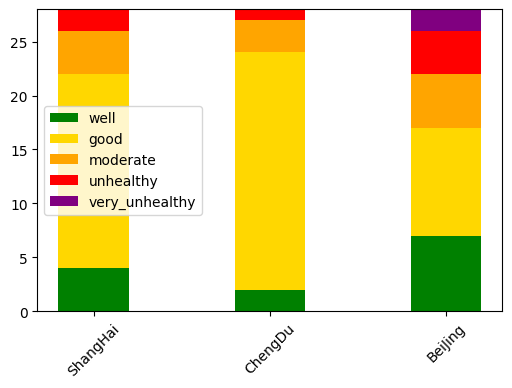

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(dpi=100)
labels = ['ShangHai','ChengDu','BeiJing']
well=np.array([4,2,7])
good=np.array([18,22,10])
moderate=np.array([4,3,5])
unhealthy=np.array([2,1,4])
very_unhealthy=np.array([0,0,2])

bar_width=0.4
 
p1=plt.bar(np.arange(len(labels)),
        well,
        color='green',
        width=bar_width, 
        label='well'
        )
p2=plt.bar(np.arange(len(labels)),
        good,
        color='gold',
        width=bar_width,
        bottom=well,
        label='good'
        )
p3=plt.bar(np.arange(len(labels)),
        moderate,
        color='orange',
        width=bar_width,
        bottom=well+good,
        label='moderate'
        )
plt.bar(np.arange(len(labels)),
        unhealthy,
        color='red',
        width=bar_width,
        bottom=well+good+moderate,
        label='unhealthy'
        )
plt.bar(np.arange(len(labels)),
        very_unhealthy,
        color='purple',
        width=bar_width,
        bottom=well+good+moderate+unhealthy,
        label='very_unhealthy'
        )
plt.xticks(np.arange(0, 3, step=1),labels,rotation=45)#定义柱子名称
plt.xticks()
plt.legend(loc="best")#图例在左边
plt.show()

## 3.影响北京、上海和程度的环境空气质量的影响因素分析

### 3.1 依据IAQI数值的统计分析

In [118]:
#城市站点个数统计
data_df.select("站号","city").distinct().groupby("city").count().show()

+--------+-----+
|    city|count|
+--------+-----+
|    昆明|   12|
|    天津|   37|
|    成都|   25|
|    郑州|   34|
|    厦门|   15|
|    青岛|   26|
|    济南|   23|
|呼和浩特|    8|
|    上海|   43|
|    海口|    6|
|乌鲁木齐|   11|
|    北京|   27|
+--------+-----+



In [119]:
#最重要的影响因素，修改计算AQI的公式，返回对应污染物的编号
def factor(a,b,c,d,e,f,g):
    #最大值函数,记录最大值和最大值的项
    arr=[a,b,c,d,e,f,g]
    num=0
    m=0
    for i,element in enumerate(arr):
        if element>=num:
            num=element
            m=i
    return  m



cal_factor=udf(factor,IntegerType())

sh_factor=sh_24_IAQI.select("year","month","day","city",cal_factor("PM25",'PM10','NO2','SO2','CO','O3-1','O3-8h').alias("factor"))
sh_factor.show(28)

+----+-----+---+----+------+
|year|month|day|city|factor|
+----+-----+---+----+------+
|2019|    2|  1|上海|     0|
|2019|    2| 21|上海|     0|
|2019|    2| 13|上海|     6|
|2019|    2|  4|上海|     0|
|2019|    2|  6|上海|     0|
|2019|    2| 23|上海|     0|
|2019|    2| 28|上海|     6|
|2019|    2| 19|上海|     2|
|2019|    2| 20|上海|     0|
|2019|    2| 18|上海|     5|
|2019|    2|  2|上海|     0|
|2019|    2|  9|上海|     6|
|2019|    2| 25|上海|     0|
|2019|    2| 12|上海|     6|
|2019|    2| 10|上海|     6|
|2019|    2| 24|上海|     0|
|2019|    2| 27|上海|     6|
|2019|    2| 14|上海|     6|
|2019|    2|  3|上海|     0|
|2019|    2| 11|上海|     6|
|2019|    2| 26|上海|     6|
|2019|    2| 16|上海|     0|
|2019|    2|  5|上海|     1|
|2019|    2| 17|上海|     5|
|2019|    2|  8|上海|     6|
|2019|    2|  7|上海|     1|
|2019|    2| 22|上海|     0|
|2019|    2| 15|上海|     6|
+----+-----+---+----+------+



In [120]:
sh_factor.groupby('factor').count().sort("count",ascending=False).show()

+------+-----+
|factor|count|
+------+-----+
|     0|   12|
|     6|   11|
|     1|    2|
|     5|    2|
|     2|    1|
+------+-----+



In [121]:
bj_factor=bj_24_IAQI.select("year","month","day","city",cal_factor("PM25",'PM10','NO2','SO2','CO','O3-1','O3-8h').alias("factor"))
bj_factor.show(28)

+----+-----+---+----+------+
|year|month|day|city|factor|
+----+-----+---+----+------+
|2019|    2| 16|北京|     6|
|2019|    2| 19|北京|     0|
|2019|    2| 20|北京|     0|
|2019|    2|  2|北京|     0|
|2019|    2|  9|北京|     6|
|2019|    2|  4|北京|     1|
|2019|    2| 25|北京|     0|
|2019|    2| 11|北京|     0|
|2019|    2|  7|北京|     6|
|2019|    2| 27|北京|     0|
|2019|    2| 22|北京|     0|
|2019|    2| 26|北京|     2|
|2019|    2|  5|北京|     0|
|2019|    2|  3|北京|     1|
|2019|    2|  1|北京|     1|
|2019|    2| 24|北京|     0|
|2019|    2|  8|北京|     1|
|2019|    2| 28|北京|     0|
|2019|    2| 17|北京|     6|
|2019|    2| 15|北京|     6|
|2019|    2| 18|北京|     0|
|2019|    2| 10|北京|     0|
|2019|    2| 21|北京|     0|
|2019|    2| 13|北京|     1|
|2019|    2| 12|北京|     1|
|2019|    2| 23|北京|     0|
|2019|    2|  6|北京|     1|
|2019|    2| 14|北京|     0|
+----+-----+---+----+------+



In [122]:
bj_factor.groupby('factor').count().sort("count",ascending=False).show()

+------+-----+
|factor|count|
+------+-----+
|     0|   15|
|     1|    7|
|     6|    5|
|     2|    1|
+------+-----+



In [123]:
cd_factor=cd_24_IAQI.select("year","month","day","city",cal_factor("PM25",'PM10','NO2','SO2','CO','O3-1','O3-8h').alias("factor"))
cd_factor.show(28)

+----+-----+---+----+------+
|year|month|day|city|factor|
+----+-----+---+----+------+
|2019|    2| 23|成都|     0|
|2019|    2| 16|成都|     1|
|2019|    2| 14|成都|     0|
|2019|    2|  4|成都|     0|
|2019|    2| 17|成都|     1|
|2019|    2| 21|成都|     0|
|2019|    2| 12|成都|     0|
|2019|    2|  9|成都|     1|
|2019|    2|  7|成都|     0|
|2019|    2| 25|成都|     0|
|2019|    2|  2|成都|     0|
|2019|    2| 11|成都|     0|
|2019|    2| 10|成都|     1|
|2019|    2| 19|成都|     0|
|2019|    2| 24|成都|     0|
|2019|    2| 26|成都|     0|
|2019|    2|  5|成都|     0|
|2019|    2|  3|成都|     0|
|2019|    2| 22|成都|     0|
|2019|    2|  1|成都|     0|
|2019|    2|  6|成都|     0|
|2019|    2|  8|成都|     0|
|2019|    2| 27|成都|     0|
|2019|    2| 13|成都|     0|
|2019|    2| 20|成都|     0|
|2019|    2| 18|成都|     6|
|2019|    2| 15|成都|     0|
|2019|    2| 28|成都|     0|
+----+-----+---+----+------+



In [124]:
cd_factor.groupby('factor').count().sort("count",ascending=False).show()

+------+-----+
|factor|count|
+------+-----+
|     0|   23|
|     1|    4|
|     6|    1|
+------+-----+



### 3.2 特征重要性分析

In [222]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [126]:
sh_ml=sh_level.select(cal_level("PM25").alias("PM25"),cal_level("PM10").alias("PM10"),
                      cal_level("NO2").alias("NO2"),cal_level("SO2").alias("SO2"),
                      cal_level("CO").alias("CO"),cal_level("O3-1").alias("O3-1"),
                      cal_level("O3-8h").alias("O3-8h"),col("等级_day").alias("label"))

sh_ml.show(5)

+----+----+---+---+---+----+-----+-----+
|PM25|PM10|NO2|SO2| CO|O3-1|O3-8h|label|
+----+----+---+---+---+----+-----+-----+
|   2|   2|  1|  1|  1|   1|    1|    2|
|   2|   2|  1|  1|  1|   1|    2|    2|
|   1|   1|  1|  1|  1|   1|    2|    2|
|   3|   3|  1|  1|  1|   1|    2|    3|
|   2|   2|  1|  1|  1|   1|    1|    2|
+----+----+---+---+---+----+-----+-----+
only showing top 5 rows



In [156]:
%%time
#离散特征编码
assembler=VectorAssembler(inputCols=['PM25','PM10','NO2','SO2','CO','O3-1','O3-8h'],outputCol="features")
# sh=assembler.transform(sh_ml).select(['features',"等级_day"])
#训练测试样本划分
(trainingData, testData) = sh_ml.randomSplit([0.7, 0.3])

# 训练模型
rf = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[assembler, rf])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       2.0|    2|[2.0,2.0,1.0,1.0,...|
|       2.0|    2|[2.0,2.0,1.0,1.0,...|
|       3.0|    4|[4.0,2.0,2.0,1.0,...|
|       2.0|    2|[2.0,2.0,1.0,1.0,...|
|       2.0|    2|[2.0,2.0,1.0,1.0,...|
+----------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.632456
RandomForestClassificationModel: uid=RandomForestClassifier_13749c81ec14, numTrees=20, numClasses=5, numFeatures=7
CPU times: user 343 ms, sys: 94.6 ms, total: 438 ms
Wall time: 2min 44s


In [157]:
#特征重要性排序
rfModel.featureImportances

SparseVector(7, {0: 0.3572, 1: 0.2484, 2: 0.0243, 5: 0.2798, 6: 0.0903})

In [229]:
#使用全部数据集计算IAQI->分等级 
array_IAQI_SO2_1h=[0,150,500,650,800,800,800,800]
cal_SO2_1h=udf(lambda x:IAQI(x,array_IAQI_SO2_1h,array_IAQI),FloatType())

array_IAQI_NO2_1h=[0,100,200,700,1200,2340,3090,3840]
cal_NO2_1h=udf(lambda x:IAQI(x,array_IAQI_NO2_1h,array_IAQI),FloatType())

array_IAQI_CO_1h=[0,5,10,35,60,90,120,150]
cal_CO_1h=udf(lambda x:IAQI(x,array_IAQI_CO_1h,array_IAQI),FloatType())

#计算IAQI 
IAQI_1h=data.select("站号","year","month","day","hour","city",
                    cal_PM25("PM25").alias("PM25"),
                    cal_PM10('PM10').alias("PM10"), 
                    cal_NO2_1h('NO2').alias("NO2"),
                    cal_SO2_1h('SO2').alias("SO2"), 
                    cal_CO_1h('CO').alias("CO"),
                    cal_O31h('O3-1').alias("O3-1"), 
                    cal_O38h('O3-8h').alias("O3-8h"))

#                     "AQI","等级")
#计算AQI和等级
AQI_1h=IAQI_1h.select("站号","year","month","day","city",'PM25','PM10','NO2','SO2','CO','O3-1','O3-8h',
                      cal_AQI("PM25","PM10","NO2","SO2","O3-1","O3-8h","CO").alias("AQI") )
AQI_1h.show()

+-----+----+-----+---+----+------+----+----+---------+----+-------+---------+---------+
| 站号|year|month|day|city|  PM25|PM10| NO2|      SO2|  CO|   O3-1|    O3-8h|      AQI|
+-----+----+-----+---+----+------+----+----+---------+----+-------+---------+---------+
|99000|2018|    8|  1|北京|  60.0|59.0|10.5|6.6666665| 0.0|   32.5|53.333332|     60.0|
|99001|2018|    8|  1|北京| 53.75|54.0|13.0|6.6666665| 0.0|   37.5|66.666664|66.666664|
|99002|2018|    8|  1|北京| 68.75|61.0|11.0|5.6666665| 0.0|35.3125|60.833332|    68.75|
|99004|2018|    8|  1|北京| 71.25|79.0|23.0|      7.0| 0.0| 20.625|     33.0|     79.0|
|99006|2018|    8|  1|北京|  75.0|65.0|13.5|0.6666667|10.0|  18.75|     30.0|     75.0|
|99007|2018|    8|  1|北京| 58.75|53.0| 5.5|0.6666667| 0.0|32.8125|54.166668|    58.75|
|99008|2018|    8|  1|北京|  77.5|69.0|13.0|      1.0| 0.0|30.9375|     49.5|     77.5|
|99009|2018|    8|  1|北京|  77.5|56.5|26.0|      1.0| 0.0|12.8125|     20.5|     77.5|
|99010|2018|    8|  1|北京|  70.0|65.0|22.5|0.666666

In [236]:
level_1h=AQI_1h.select("站号","year","month","day","city",'PM25','PM10','NO2','SO2','CO','O3-1','O3-8h',"AQI",cal_level("AQI").alias("等级"))

level_1h.show(5)


+-----+----+-----+---+----+-----+----+----+---------+----+-------+---------+---------+----+
| 站号|year|month|day|city| PM25|PM10| NO2|      SO2|  CO|   O3-1|    O3-8h|      AQI|等级|
+-----+----+-----+---+----+-----+----+----+---------+----+-------+---------+---------+----+
|99000|2018|    8|  1|北京| 60.0|59.0|10.5|6.6666665| 0.0|   32.5|53.333332|     60.0|   2|
|99001|2018|    8|  1|北京|53.75|54.0|13.0|6.6666665| 0.0|   37.5|66.666664|66.666664|   2|
|99002|2018|    8|  1|北京|68.75|61.0|11.0|5.6666665| 0.0|35.3125|60.833332|    68.75|   2|
|99004|2018|    8|  1|北京|71.25|79.0|23.0|      7.0| 0.0| 20.625|     33.0|     79.0|   2|
|99006|2018|    8|  1|北京| 75.0|65.0|13.5|0.6666667|10.0|  18.75|     30.0|     75.0|   2|
+-----+----+-----+---+----+-----+----+----+---------+----+-------+---------+---------+----+
only showing top 5 rows



In [237]:
level_1h.filter((level.city == '北京')  &  ((data_df.month == '6'))).show()

+-----+----+-----+---+----+---------+----+----+----------+----+-------+----------+----------+----+
| 站号|year|month|day|city|     PM25|PM10| NO2|       SO2|  CO|   O3-1|     O3-8h|       AQI|等级|
+-----+----+-----+---+----+---------+----+----+----------+----+-------+----------+----------+----+
|99000|2019|    6|  8|北京|42.857143|48.0| 9.5| 3.6666667| 0.0|  28.75| 98.333336| 98.333336|   2|
|99001|2019|    6|  8|北京|     50.0|46.0| 9.5| 4.6666665| 0.0| 29.375| 103.63636| 103.63636|   3|
|99002|2019|    6|  8|北京| 38.57143|53.5|12.0| 1.6666666| 0.0|   27.5|      92.5|      92.5|   2|
|99004|2019|    6|  8|北京|45.714287|51.0|11.0| 3.6666667| 0.0| 26.875| 102.72727| 102.72727|   3|
|99009|2019|    6|  8|北京|     97.5|62.5|14.5|       1.0| 0.0| 18.125| 80.833336|      97.5|   2|
|99010|2019|    6|  8|北京|   123.75|78.5|30.0|       1.0|10.0| 18.125| 90.833336|    123.75|   3|
|99011|2019|    6|  8|北京|    110.0|68.5|18.0|0.33333334| 0.0|30.3125| 100.90909|     110.0|   3|
|99013|2019|    6|  8|北京|   

In [238]:
level=level_1h.select("站号","year","month","day","city",cal_level("PM25").alias("PM25"),cal_level("PM10").alias("PM10"),
                      cal_level("NO2").alias("NO2"),cal_level("SO2").alias("SO2"),
                      cal_level("CO").alias("CO"),cal_level("O3-1").alias("O3-1"),
                      cal_level("O3-8h").alias("O3-8h"),col("等级").alias("label"),
                      cal_factor("PM25",'PM10','NO2','SO2','CO','O3-1','O3-8h').alias("factor"))

level.show(5)

+-----+----+-----+---+----+----+----+---+---+---+----+-----+-----+------+
| 站号|year|month|day|city|PM25|PM10|NO2|SO2| CO|O3-1|O3-8h|label|factor|
+-----+----+-----+---+----+----+----+---+---+---+----+-----+-----+------+
|99000|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    2|    2|     0|
|99001|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    2|    2|     6|
|99002|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    2|    2|     0|
|99004|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    1|    2|     1|
|99006|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    1|    2|     0|
+-----+----+-----+---+----+----+----+---+---+---+----+-----+-----+------+
only showing top 5 rows



In [239]:
level.filter(level.city == '北京').groupby("month").count().show()

+-----+-----+
|month|count|
+-----+-----+
|    8| 9812|
|    6| 1297|
|    1|14602|
|    2|11820|
+-----+-----+



In [243]:
#筛选北京的1月，2月的数据特征重要性排序  
bj_ml=level.filter((level.city == '北京')  &  ((data_df.month == '6')|(data_df.month == '8')) )
print(bj_ml.count())
bj_ml.show(5)

11109
+-----+----+-----+---+----+----+----+---+---+---+----+-----+-----+------+
| 站号|year|month|day|city|PM25|PM10|NO2|SO2| CO|O3-1|O3-8h|label|factor|
+-----+----+-----+---+----+----+----+---+---+---+----+-----+-----+------+
|99000|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    2|    2|     0|
|99001|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    2|    2|     6|
|99002|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    2|    2|     0|
|99004|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    1|    2|     1|
|99006|2018|    8|  1|北京|   2|   2|  1|  1|  1|   1|    1|    2|     0|
+-----+----+-----+---+----+----+----+---+---+---+----+-----+-----+------+
only showing top 5 rows



In [244]:
bj_ml.groupby('factor').count().sort("count",ascending=False).show()

+------+-----+
|factor|count|
+------+-----+
|     6| 4890|
|     0| 2540|
|     1| 2500|
|     5| 1121|
|     2|   36|
|     3|   17|
|     4|    5|
+------+-----+



In [178]:
# data.select([count(when(isnan(c),c)).alias(c) for c in data.columns]).show()

+----+----+----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
|站号|经度|纬度|PM25|PM10|NO2|SO2|O3-1|O3-8h| CO|AQI|等级|year|month|day|hour|city|
+----+----+----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+
|   0|   0|   0|   0|   0|  0|  0|   0|    0|  0|  0|   0|   0|    0|  0|   0|   0|
+----+----+----+----+----+---+---+----+-----+---+---+----+----+-----+---+----+----+



In [182]:
# bj_ml.na.fill(0)

DataFrame[站号: string, year: string, month: string, day: string, hour: string, city: string, PM25: int, PM10: int, NO2: int, SO2: int, CO: int, O3-1: int, O3-8h: int, label: int, factor: int]

In [183]:
# bj_ml.select([count(when(isnan(c),c)).alias(c) for c in bj_ml.columns]).show()

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 605, in main
    process()
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 597, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/serializers.py", line 223, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/serializers.py", line 212, in _batched
    for item in iterator:
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 90, in <lambda>
    return lambda *a: f(*a)
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/util.py", line 107, in wrapper
    return f(*args, **kwargs)
  File "/usr/spark-3.0.1-bin-without-hadoop/python/lib/pyspark.zip/pyspark/worker.py", line 82, in <lambda>
    return lambda *a: g(f(*a))
  File "<ipython-input-163-954016a9b19c>", line 6, in <lambda>
  File "<ipython-input-162-3a7818c5a160>", line 7, in level
TypeError: '<' not supported between instances of 'int' and 'NoneType'


In [245]:
bj_ml=bj_ml.select('PM25','PM10','NO2','SO2','CO','O3-1','O3-8h','label')
bj_ml.show(5)
bj_ml.printSchema()

assembler=VectorAssembler(inputCols=['PM25','PM10','NO2','SO2','CO','O3-1','O3-8h'],outputCol="features")
indexer=VectorIndexer(maxCategories=10, inputCol="features", outputCol="indexed")

#训练测试样本划分
(trainingData, testData) = bj_ml.randomSplit([0.7, 0.3])

# 训练模型
rf = RandomForestClassifier(featuresCol="indexed")

pipeline = Pipeline(stages=[assembler,indexer, rf])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
predictions.select("prediction", "label", "features").show(5)
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

weightedPrecision = evaluator.evaluate(predictions)
print("precision on test data = %g" % weightedPrecision)

rfModel = model.stages[2]
print(rfModel) 

rfModel.featureImportances

+----+----+---+---+---+----+-----+-----+
|PM25|PM10|NO2|SO2| CO|O3-1|O3-8h|label|
+----+----+---+---+---+----+-----+-----+
|   2|   2|  1|  1|  1|   1|    2|    2|
|   2|   2|  1|  1|  1|   1|    2|    2|
|   2|   2|  1|  1|  1|   1|    2|    2|
|   2|   2|  1|  1|  1|   1|    1|    2|
|   2|   2|  1|  1|  1|   1|    1|    2|
+----+----+---+---+---+----+-----+-----+
only showing top 5 rows

root
 |-- PM25: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- NO2: integer (nullable = true)
 |-- SO2: integer (nullable = true)
 |-- CO: integer (nullable = true)
 |-- O3-1: integer (nullable = true)
 |-- O3-8h: integer (nullable = true)
 |-- label: integer (nullable = true)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|    1|[1.0,1.0,1.0,1.0,...|
|       1.0|    1|[1.0,1.0,1.0,1.0,...|
|       1.0|    1|[1.0,1.0,1.0,1.0,...|
|       1.0|    1|[1.0,1.0,1.0,1.0,...|
|       1.0|    1|[1.0,1.0

SparseVector(7, {0: 0.1184, 1: 0.2802, 2: 0.0, 3: 0.0011, 4: 0.0003, 5: 0.1325, 6: 0.4674})